# Chargement des modules 

In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint
import seaborn as sb
import folium
import json
import scipy.stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Données
Nos données correspondent à l'ensemble des transactions sur les horodateurs dans la ville de Paris sur l'année 2014. Celles-ci proviennent du site Open Data Paris, répertoire des données ouvertes de la ville de Paris. Elles sont stockées sur le serveur MongoDB, dans la base `horodateurs`.

Elle contient deux collections principales :
- `transactions` : ensemble des paiements
- `mobiliers` : liste de tous les horodateurs


In [2]:
con = pymongo.MongoClient("mongodb://193.51.82.104:2343/")

horo = con.horodateurs
horo.list_collection_names()

['transactions_small', 'myresults', 'transactions', 'mobiliers']

Pour commencer, nous allons afficher la carte de Paris délimitée par ses arrondissements.

In [3]:
geo = json.load(open("paris-arrondissements.geojson"))

centre_paris = [48.86, 2.35]
carte_arrond = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo).add_to(carte_arrond)
carte_arrond

# Familiarisation avec les données 
#### Création de la fonction affiche pour le travail suivant 

In [4]:
def affiche(res):
    pprint.pprint(list(res))

## Collection `mobiliers`
Nous allons commencer par étudier la collection `mobiliers`.  
De plus, nous allons transformer cette collection en DataFrame afin de décrire au mieux les données à l'aide de différents graphiques :

In [5]:
res = horo.mobiliers.distinct('fields')
data_mob = pd.DataFrame(list(res))

In [6]:
print(data_mob.shape)
data_mob.head()

(7810, 12)


,adresse,alim,arrondt,geo_point_2d,geo_shape,modele,numhoro,objectid,regime,tarif,tarifhor,zoneres
0,48 vis-à-vis RUE DE LISBONNE,SOLAIRE,8,"[48.877489999731374, 2.311394999713242]","{'type': 'Point', 'coordinates': [2.3113949997...",SAB3,57080603,4383,MIX,"4,00 E MIX 2U",4.0,8J
1,21 RUE LEON GIRAUD,PILE,19,"[48.88819100008769, 2.3836700005400373]","{'type': 'Point', 'coordinates': [2.3836700005...",SMB2,55580201,4291,MIX,"2,40 E MIX 2U",2.4,19K
2,13 RUE LEON JOST,SOLAIRE,17,"[48.880837000075445, 2.302239999461189]","{'type': 'Point', 'coordinates': [2.3022399994...",SAB3,55660201,4295,MIX,"2,40 E MIX 2U",2.4,17J
3,149 RUE LEON MAURICE NORDMANN,SOLAIRE,13,"[48.83351900035392, 2.342770000389364]","{'type': 'Point', 'coordinates': [2.3427700003...",SAB3,55700501,4302,MIX,"2,40 E MIX 2U",2.4,13H
4,28 RUE LEPIC,PILE,18,"[48.885410999990484, 2.334458000377144]","{'type': 'Point', 'coordinates': [2.3344580003...",SMB2,55950402,4311,ROT,"2,40 E ROT 2U",2.4,18F


### Quels sont les différents types d'alimentation pour les horodateurs ? Quels sont leur nombre?

In [7]:
horo.mobiliers.distinct('fields.alim')

['SOLAIRE', 'PILE']

In [8]:
horo.mobiliers.count_documents({'fields.alim' : 'SOLAIRE'})

4808

In [9]:
horo.mobiliers.count_documents({'fields.alim' : 'PILE'})

2994

On peut le résumer plus facilement à l'aide du dataframe `data_mob` : 

In [10]:
data_mob.groupby('alim')['adresse'].count()

alim
PILE       2994
SOLAIRE    4808
Name: adresse, dtype: int64

#### Cartes réprésentant la répartition des différents types d'alimentations
On commence par regarder les horodateurs alimentés par le soleil : 

In [12]:
t = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "alim": "$fields.alim", "arr": "$fields.arrondt" }, "Nombre": { "$sum": 1 }}},
    { "$project": { "Arrondissement": "$_id.arr", "Alimentation": "$_id.alim", "Nombre": 1, "_id": 0 }}
]))) #on remarque que l'on a quand même beaucoup de valeurs manquantes

t2 = t[t.Alimentation == 'SOLAIRE']

carte = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = t2, columns = ['Arrondissement', 'Nombre'],
                 fill_color = 'Spectral', legend_name = "Nombre d'horodateurs aliméntés par le soleil").add_to(carte)
#carte
#la carte ne s'affiche pas  : il semblerait que les cartes prennent un trop grand espace de sauvegarde

On regarde ensuite la répartiton des horodateurs alimenté par pile. 

In [13]:
t3 = t[t.Alimentation == 'PILE']
carte = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = t3, columns = ['Arrondissement', 'Nombre'],
                 fill_color = 'Spectral', legend_name = "Nombre d'horodateurs aliméntés par pile").add_to(carte)
#carte
#la carte ne s'affiche pas  : il semblerait que les cartes prennent un trop grand espace de sauvegarde

 ### Combien y a-t'il d'horodateur par arrondissement?

In [14]:
res = horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1}}},
    { "$sort" : { "_id": 1}}
])
df = pd.DataFrame(list(res)) 
df.columns = ["Arrondissement", "Effectif"]
df.head()

,Arrondissement,Effectif
0,1,87
1,2,67
2,3,133
3,4,135
4,5,267


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13d1ba9e48>],
      dtype=object)

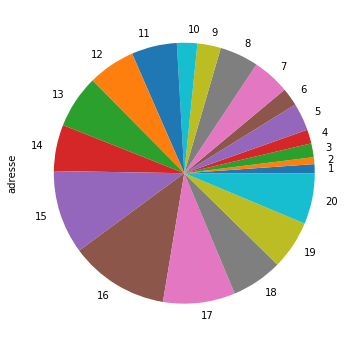

In [15]:
df2 = data_mob.groupby('arrondt')['adresse'].count()
df2.plot.pie(subplots = True, figsize = (6,6))

On remarque que les arrondissements au centres de Paris (1 à 11) possèdent beaucoup moins d'horodateurs que ceux à l'extérieur du centre de Paris.

### Quels sont les différents modèles d'horodateurs ?

In [16]:
horo.mobiliers.distinct('fields.modele')

['SAB3', 'SMB2', 'MUI']

Nous allons pousser plus loin l'étude de la variable `modele`, nous allons regarder quels modèles d'horodateurs sont les plus présents dans chacun des arrondissement : 

In [17]:
t = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "modele": "$fields.modele", "arr": "$fields.arrondt" }, "Nombre": { "$sum": 1 }}},
    { "$project": { "Arrondissement": "$_id.arr", "Modeles": "$_id.modele", "Nombre": 1, "_id": 0 }}
])))

t.head()

,Arrondissement,Modeles,Nombre
0,20,SMB2,1
1,1,MUI,1
2,9,SMB2,1
3,18,NaN,1
4,7,SAB3,45


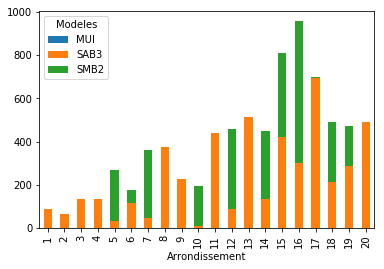

In [18]:
t2 = pd.crosstab(t.Arrondissement, t.Modeles, values = t.Nombre, aggfunc = np.sum)
t2.plot.bar(stacked = True)

D'après le diagramme en barre ci-dessus, on remarque qu'il n'y a pas ou très peu d'horodateurs de type `MUI`.  
De plus, modèle `SAB3` semble le plus présent.  

### Quels sont les types de régimes qui sont les plus présents en fonction des arrondissements?

In [19]:
t = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "regime": "$fields.regime", "arr": "$fields.arrondt" }, "Nombre": { "$sum": 1 }}},
    { "$project": { "Arrondissement": "$_id.arr", "Regime": "$_id.regime", "Nombre": 1, "_id": 0 }}
])))
t.head()

,Arrondissement,Nombre,Regime
0,1,24,ROT
1,16,74,ROT
2,7,24,ROT
3,3,82,MIX
4,5,26,ROT


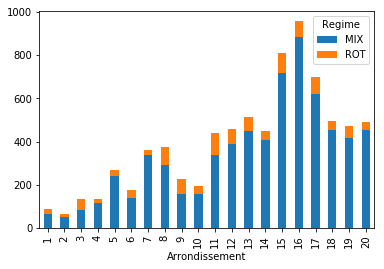

In [20]:
t2 = pd.crosstab(t.Arrondissement, t.Regime, values=t.Nombre, aggfunc= np.sum)

t2.plot.bar(stacked = True)

On voit qu'il y a beaucoup plus de régime `MIX`, qui correspond aux horodateurs situés sur des voies mixtes, que de régime `ROT`, qui correspond aux horodateurs situés sur des voies rotatives, pour chacun des arrondissements.  

#### Cartes réprésentant la répartition des différents types de mobilier 
On commence par regarder les horodateurs rotatifs : 

In [21]:
t2 = t[t.Regime == 'ROT']

carte = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = t2, columns = ['Arrondissement', 'Nombre'],
                 fill_color = 'Spectral', legend_name = "Nombre horodateurs rotatifs").add_to(carte)
carte

D'après la carte ci-dessus représentant les nombres d'horodateurs rotatifs par arrondissements, on peut voir que les arrondissements disposant le plus de ce type d'horodateurs sont le quinzième et la onzième arrondissements. Au contraire, ceux qui en possèdent le moins sont situés dans le centre de Paris.  

On décide alors en utilisant la même méthode, de représenter les nombres d'horodateurs de type mixtes.

In [22]:
t3 = t[t.Regime == 'MIX']

carte = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = t3, columns = ['Arrondissement', 'Nombre'],
                 fill_color = 'Spectral', legend_name = "Nombre horodateurs mixtes").add_to(carte)
carte

D'après la carte ci-dessus représentant les nombres d'horodateurs mixtes par arrondissements, on peut voir que l'arrondissement disposant le plus de ce type d'horodateurs est le seizième arrondissements. Au contraire, ceux qui en possèdent le moins sont situés dans le centre de Paris.  
  
Au vu de ces deux cartes, on peut dire que le centre de Paris possède moins d'horodateurs (peu importe le type) que dans les autres arrondissements. 

### Quels sont les différents tarifs horaires par arrondissement ?

In [23]:
t = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "Arrondissement": "$fields.arrondt", "Tarif": "$fields.tarifhor" }, "Nombre": { "$sum": 1 }}},
    { "$project": { "Tarifs": "$_id.Tarif", "Arrondissement": "$_id.Arrondissement", "Nombre": 1, "_id": 0 }}
])))
t.head()

,Arrondissement,Nombre,Tarifs
0,2,67,4.0
1,7,361,4.0
2,6,174,4.0
3,10,197,4.0
4,14,448,2.4


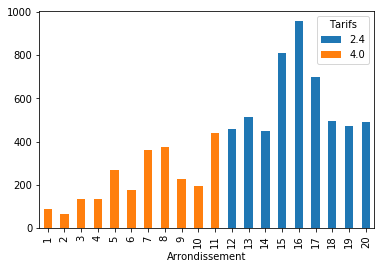

In [24]:
t2 = pd.crosstab(t.Arrondissement, t.Tarifs, values = t.Nombre, aggfunc = np.sum)
t2.plot.bar(stacked = True)

#### Carte représentant le tarif par arrondissement

In [25]:
carte = folium.Map(location = centre_paris, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = t, columns = ["Arrondissement", "Tarifs"],
                 fill_color= "Spectral",
                 legend_name = "Tarif par arrondissement").add_to(carte)
carte

D'après la carte ci-dessus qui représente les tarifs par arrondissements, on commence par remarquer que les tarifs sont fixe suivant l'arrondissement.  
De plus, à l'aide du diagramme en barre associé, on remarque que pour les arrondissements 1 à 11 le tarif est de 4€ tandis que pour les arrondissements 12 à 20 le tarif est de 2.40€.  
On peut dire que cette différence peut être du au tourisme, en effet les arrondissements les plus touristiques sont situés au centre de Paris.  

## Collection `transactions` 
Pour cette collection, comme nous avons vu précédemment, elle contient beaucoup de données, alors pour tester nos résultats nous préférons utiliser la collection `transactions_small`.  
De plus, nous allons transformer cette collection en DataFrame afin de décrire au mieux les données :  

In [26]:
data_trans = pd.DataFrame(list(horo.transactions_small.find()))

In [27]:
print(data_trans.shape)
data_trans.head()

(244480, 10)


,_id,date horodateur,durée payée (h),début stationnement,fin stationnement,horodateur,montant,montant carte,moyen de paiement,usager
0,56eaaa009fae0d71f756f620,2014-07-16 12:51:09,1.00,2014-07-16 12:51:09,2014-07-16 13:51:09,36590413,1.2,NaN,Paris Carte,Rotatif
1,56eaa8949fae0d71f7b0c10e,2014-02-18 13:57:30,2.00,2014-02-18 13:57:30,2014-02-18 15:57:30,38730902,NaN,4.8,CB,Rotatif
2,56eaaacd9fae0d71f7b4745b,2014-10-29 15:37:38,0.25,2014-10-29 15:37:38,2014-10-29 15:52:00,96230204,NaN,0.6,Paris Carte,Rotatif
3,56eaab4a9fae0d71f7ec186b,2014-12-27 16:51:57,1.75,2014-12-27 16:51:57,2014-12-27 18:36:57,21850302,NaN,6.3,CB,Rotatif
4,56eaa9c69fae0d71f73d0383,2014-06-19 09:41:47,2.00,2014-06-19 09:41:47,2014-06-19 11:41:47,98530506,NaN,4.8,Paris Carte,Rotatif


### Distribution des montants payés (`montant carte`) et des durées payées (`durée payée (h)`)

In [39]:
usager = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$usager", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
usager_eff=pd.DataFrame(usager)
usager_eff

,_id,nb
0,Rotatif,190206
1,Résident,54274


Il y a plus d'usager rotatifs que d'usager résidents dans Paris. 

Voici un aperçu de la répartition du montant payé dans la base de données : 

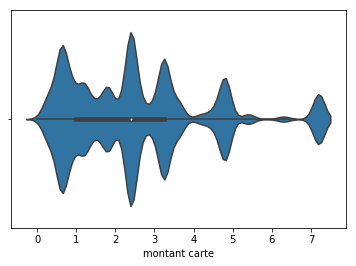

In [40]:
sb.violinplot(x = "montant carte", data = data_trans)

Le montant payé varie selon à peu près 5 gros groupes de personnes, il y a le premier groupe de personne qui paye un montant inférieur à 1€, un second groupe qui paye un tarif compris entre 2 et 3€, un troisième qui paye un peu plus de 3€, un quatrième qui paye un montant presque égal à 5€ et un dernier groupe qui paye un tarif supérieur à 7€.

Nous allons voir ce que donne l'histogramme de la répartition des montants :

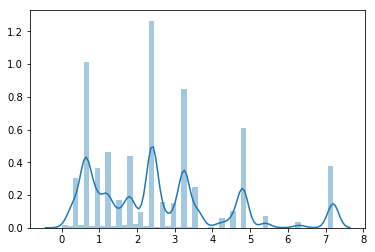

In [41]:
tab_montant = list(horo.transactions_small.find({}, {"_id": 0, "montant carte" : 1}))
montant_carte = pd.DataFrame(tab_montant)
montant2=montant_carte.dropna()
sb.distplot(montant2)

Nous retrouvons bien les 5 plus gros groupes de personnes que nous avons observé sur le graphique précédent.   Concernant les personnes qui ne se trouve pas dans ces gros groupes elles sont une majorité à payer entre 1 et 2€.  
La densité de cette distribution ne ressemble pas à celle d'une loi normale.

Nous allons également regarder si il y a une différence de montant entre usager rotatif et usager résident : 

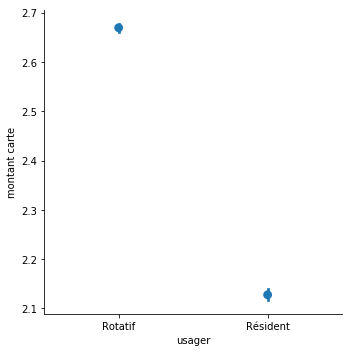

In [42]:
sb.catplot(x = "usager", y = "montant carte", data = data_trans, kind = "point", join = False)

Le montant moyen des usagers rotatifs est supérieur à celui des usagers résidents. 

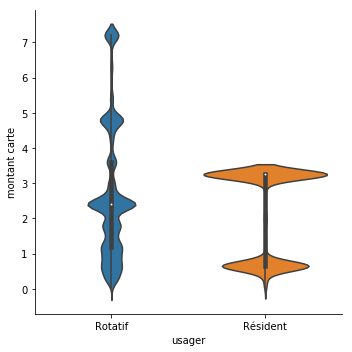

In [43]:
sb.catplot(x = "usager", y = "montant carte", data = data_trans, kind = "violin", join = False)

Si l'on compare le montant payé par les usagers rotatifs à ceux des résidents, on remarque d'abord que le montant varie plus chez les rotatifs que chez les résidents.  
Chez les usagers rotatifs, on observe une répartition d'effectif qui reste constante jusqu'au tarif de 2€, à partir de 2€ la répartition fait un bond puis s'affine avant de rebondir, on observe 3 fois ce phénomène. Ce qui semble dire qu'il y a une partie des usagers rotatifs qui payent un montant élevés par rapport aux autres et qui fait donc pousser la moyenne vers le haut alors que la plupart de usagers rotatifs ne payent pas un montant aussi cher.  
Chez les usagers résident, il y a une hétérogéinité flagrante, il y a d'un côté les résidents qui payent entre 0 et 1€ et de l'autre il y a ceux qui payent plus de 3€. Et les résidents qui payent plus de 3€ sont plus nombreux que ceux qui payent entre 0€ et 1€.

On étudie maintenant la distribution des durées payés : 

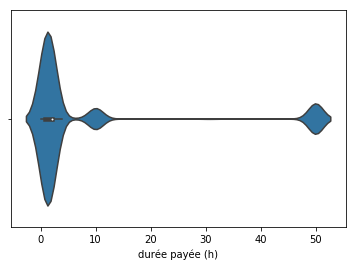

In [44]:
sb.violinplot(x = "durée payée (h)", data = data_trans)

La répartition des durées payés est très hétérogène.    
Il y a d'un côté les usagers qui stationnent entre 0 et 7h dans une journée.   
Certain stationnent pendant pendant une durée de 10h.   
On remarque aussi qu'il y a des usagers qui stationnent pendant 50h soit plus de deux jours dans Paris.

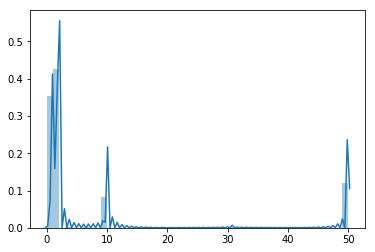

In [45]:
tab_duree = list(horo.transactions_small.find({}, {"_id": 0, "durée payée (h)" : 1}))
duree = pd.DataFrame(tab_duree)
duree2=duree .dropna()
sb.distplot(duree2)

La majorité des usagers stationnent entre 0 et 2h dans Paris.   
L'autre partie stationnent beaucoup plus longtemps soit 10h soit 50h.

Cette hétérogéinité aura certainement l'influence de tirer la durée moyenne de stationnement vers le haut.

Nous allons donc essayer de comprendre en regardant les durées moyennes par type d'usager.

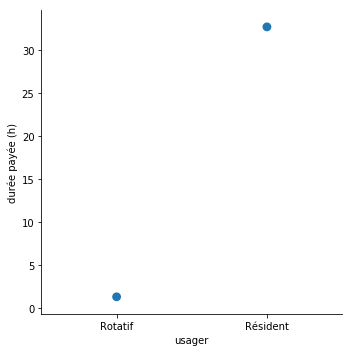

In [46]:
sb.catplot(x = "usager", y = "durée payée (h)", data = data_trans, kind = "point", join = False)

Les résidents stationnent en moyenne beaucoup plus longtemps que les usagers rotatifs qui eux doivent être la partie des usagers qui stationnent entre 0 et 2h.  
Nous allons vérifier cette hypothèse à l'aide du strip plot.

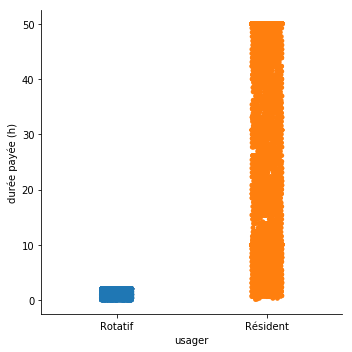

In [47]:
sb.catplot(x = "usager", y = "durée payée (h)", data = data_trans, kind = "strip")

Effectivement, les usagers rotatifs ne stationnement pas plus de 2h dans Paris.   
Les résidents quant à eux ne possède pas de durée précise de stationnement, il peuvent stationner dans Paris pour quelques heures ou pour toute une journée et voir pour plusieurs journées.

Cela peut-être s'expliquer par le fait que le stationnement est moins cher pour les usagers résidents à Paris.


### Liste des différents moyens de paiements utilisés (`moyen de paiement`) et le type d'usager (`usager`), en ordonnant chaque table résultat par ordre décroissant du nombre de paiements 

In [48]:
t = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
moyen_paiement=pd.DataFrame(t)
moyen_paiement

,_id,nb
0,Paris Carte,132453
1,CB,112027


Il y a plus de personne qui paye en Paris Carte que de personnes qui payent en CB.

In [31]:
affiche(horo.transactions_small.distinct('moyen de paiement'))
affiche(horo.transactions_small.distinct('usager'))

['Paris Carte', 'CB']
['Rotatif', 'Résident']


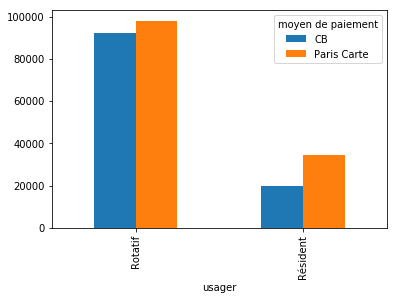

In [32]:
t = pd.crosstab(data_trans['usager'], data_trans['moyen de paiement'])
t.plot.bar()

Les usagers rotatifs utilisent beaucoup le type de paiement CB et Paris Carte. Les usagers rotatifs utilisent un peu plus le mode de paiement Paris Carte que le mode de paiement CB. Les usagers rotatifs utilisent beaucoup plus les moyen de paiement CB et Paris carte que les usagers résidents. Les usagers résidents quant à eux utilisent plus le mode de paiement Paris Carte que CB.

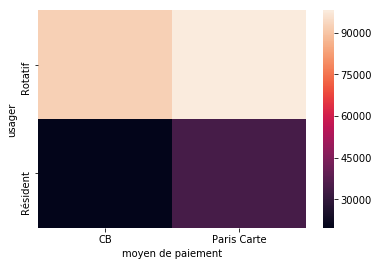

In [49]:
paiement= data_trans["moyen de paiement"]
sb.heatmap(pd.crosstab(data_trans.usager,paiement ))

On peut confirmer que le nombre de paiement est plus élevé pour le type de paiement Paris Carte pour tous les types d'usagers.

In [ ]:
nb_paiement = pd.DataFrame(list(horo.transactions.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.moyen de paiement",
        "foreignField": "horodateur",
        "as": "transaction"
    }},   
    { "$unwind" : "$transaction"},
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1 }}},
    { "$project": { "Arrondissement": "$_id", "Moyen de paiement": "$nb", "_id": 0 }},
    { "$sort" : {"Arrondissement": 1}}
])))
nb_paiement

### Y-a-t'il un lien entre le moyen de paiement et le montant ?
Voici le descriptif du moyen de paiement en fonction du montant de la carte :

In [33]:
data_paie_mont = data_trans.groupby("moyen de paiement")["montant carte"].agg([np.mean, np.std, np.median, np.min, np.max])
data_paie_mont

,mean,std,median,amin,amax
moyen de paiement,,,,,
CB,3.007229,1.798944,2.4,0.15,7.2
Paris Carte,2.161545,1.644935,1.8,0.01,7.2


On souhaite ensuite appliquer le test de Student, où l'on teste : 
- $H_0$ : $\mu_{CB} = \mu_{PC}$
- $H_1$ : $\mu_{CB} \ne \mu_{PC}$
  
Avec : 
- $\mu_{CB}$ la moyenne de paiement par CB  selon le montant
- $\mu_{PC}$ la moyenne de paiement par Paris Carte

In [34]:
data= data_trans.filter(['montant carte', 'moyen de paiement'])
dataCB = data[data['moyen de paiement'] == 'CB']
dataPC = data[data['moyen de paiement'] == 'Paris Carte'] 

#On enlève les valeurs manquantes pour effectuer le test de Student
dataCB = dataCB.dropna()
dataPC = dataPC.dropna()

#On effectue le test de Student 
test = scipy.stats.ttest_ind(dataCB['montant carte'], dataPC['montant carte'])
print(test)

Ttest_indResult(statistic=121.32549065089455, pvalue=0.0)


On remarque que la pvalue associée à notre test est égale à 0 qui est plus petite que $\alpha = 0.05$ : on décide donc $H_1$.  
Les moyennes ne peuvent donc pas être considérée comme égale.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13d01471d0>,
      dtype=object)

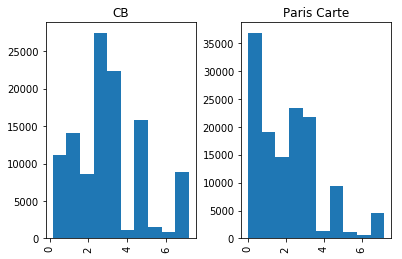

In [35]:
data_trans.hist(column = "montant carte", by = "moyen de paiement")

### Y-a-t'il un lien entre le moyen de paiement et la durée payée ?

In [36]:
data_trans.groupby("moyen de paiement")["durée payée (h)"].agg([np.mean, np.std, np.median, np.min, np.max])

,mean,std,median,amin,amax
moyen de paiement,,,,,
CB,8.254365,16.412833,2.0,0.03,50.0
Paris Carte,8.261151,15.677414,1.5,0.01,50.0


On remarque que la moyenne de paiement par CB lié à la durée payée et celle de paiement par Paris Carte lié à la durée payée sont très proches.  
On décide donc de faire un test de Student afin de savoir si on peut considérer leurs moyennes égales ou non.  
On fait ce test au niveau $\alpha$ = 5%.  
On test alors : 
- $H_0$ : $\mu_{CB} = \mu_{PC}$
- $H_1$ : $\mu_{CB} \ne \mu_{PC}$
  
Avec : 
- $\mu_{CB}$ la moyenne de paiement par CB  selon la durée payée
- $\mu_{PC}$ la moyenne de paiement par Paris Carte selon la durée payée

In [37]:
data= data_trans.filter(['durée payée (h)', 'moyen de paiement'])
dataCB = data[data['moyen de paiement'] == 'CB']
dataPC = data[data['moyen de paiement'] == 'Paris Carte'] 

#On enlève les valeurs manquantes pour effectuer le test de Student
dataCB = dataCB.dropna()
dataPC = dataPC.dropna()

#On effectue le test de Student 
test = scipy.stats.ttest_ind(dataCB['durée payée (h)'], dataPC['durée payée (h)'])
print(test)

Ttest_indResult(statistic=-0.10436693134104658, pvalue=0.9168782499158954)


On remarque que la pvalue associée à notre test est égale à 0.92 qui est significativement plus grande que $\alpha = 0.05$ : on décide donc $H_0$.  
Les moyennes peuvent donc être considérée comme égale.

## Jointure entre collections 
Il est possible de réaliser une jointure entre deux collections, dans un aggrégat, avec l'opérateur `$lookup`.

Ci-dessous, nous nous restreignons aux transactions de l'horodateur `57080603`. Ensuite, nous récupérons les informations de celui-ci dans l'autre collection (indiquée dans le `from`), via la jointure avec `$lookup`. L'attribut `localField` indique l'attribut à prendre dans la collection en cours et `foreignField` l'attribut à prendre dans la collection indiquée dans le `from`. La liste des mobiliers correspondants (1 seul normalement ici) est retournée dans un array nommé via le as. Ensuite, nous nous limitons aux 5 premiers résultats pour ne pas alourdir l'affichage.

In [38]:
res = horo.transactions_small.aggregate([
    { "$match": { "horodateur": 57080603}},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "horodateur",
        "foreignField": "fields.numhoro",
        "as": "mobilier"
    }},
    { "$limit": 5}
])
liste = list(res)

### Quel est le nombre de transactions par arrondissement ?

In [13]:
nb_transac = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transaction"
    }},   
    { "$unwind" : "$transaction"},
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1 }}},
    { "$project": { "Arrondissement": "$_id", "Nombre de transactions": "$nb", "_id": 0 }},
    { "$sort" : {"Arrondissement": 1}}
])))
nb_transac

,Arrondissement,Nombre de transactions
0,1,2539
1,2,1787
2,3,4250
3,4,3884
4,5,9005
5,6,6784
6,7,12024
7,8,15113
8,9,8021
9,10,5487


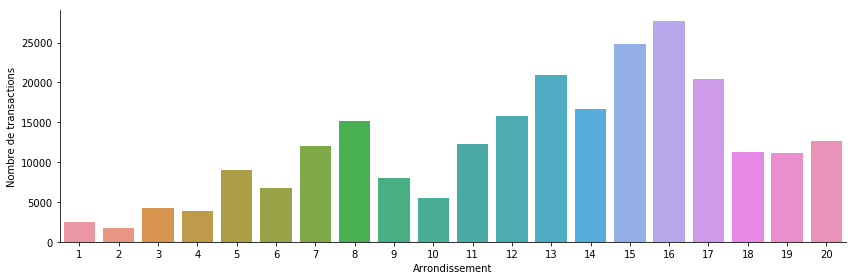

In [18]:
sb.catplot(x = "Arrondissement", y = "Nombre de transactions",
                data = nb_transac, kind = "bar", height = 4, aspect = 3)

D'après le graphique ci-dessus, on s'aperçoit que le seizième arrondissement est celui ayant connu le plus grand nombre de transactions (27 718) tandis que l'arrondissement parisien ayant eu le moins de transactions parmi tous est le second arrondissement (1 787).

### Quel est le montant total par arrondissement ?

In [39]:
montant_total = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$limit" : 5000},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transaction"
    }},
    { "$unwind" : "$transaction"},
    { "$group" : { "_id" : "$fields.arrondt", "Total" : { "$sum" : "$transaction.montant carte" }}},
    { "$project": { "Arrondissement": "$_id", "Total des transactions (en €)": "$Total", "_id": 0 }},
    { "$sort": {"Arrondissement": 1}}
])))

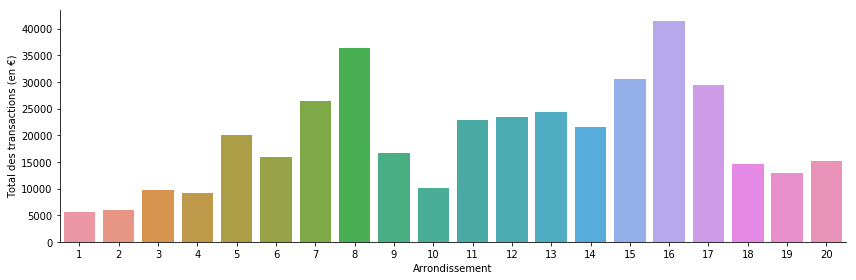

In [41]:
sb.catplot(x = "Arrondissement", y = "Total des transactions (en €)",
           data = montant_total, kind = "bar", height = 4, aspect = 3)

D'après le graphique ci-dessus, on remarque que le deuxième arrondissement est l'arrondissement dont le total des transactions est le plus faible (7 466,09 euros) alors qu'au contraire le seixième arrondissement possède le total des transactions le plus haut (64 843,64 euros).

### Quel est le montant moyen par arrondissement ?

In [42]:
montant_moyen = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transaction"
    }},
    { "$unwind" : "$transaction"},
    { "$group" : { "_id" : "$fields.arrondt", "Total" : { "$avg" : "$transaction.montant carte" }}},
    { "$project": { "Arrondissement": "$_id", "Moyenne des transactions (en €)": "$Total", "_id": 0 }},
    { "$sort": {"Arrondissement": 1}}
])))

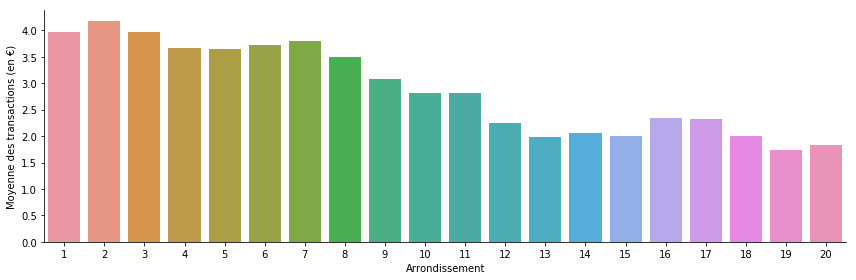

In [43]:
sb.catplot(x = "Arrondissement", y = "Moyenne des transactions (en €)",
                data = montant_moyen, kind = "bar", height = 4, aspect = 3)

D'après le diagramme en barre, on peut constater que le dix-neuvième arrondissement a la plus faible moyenne des transactions dans Paris alors que le deuxième arrondissement est celui dont la moyenne des transactions est la plus élevée.

### Quelle est la rentabilité par arrondissement?

In [103]:
rentabilite = pd.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    {"$unwind": "$transactions"},
    {"$limit": 20000},
    {"$group": {"_id": {"arrondissement": "$fields.arrondt"}, "Recette": {"$sum": "$transactions.montant carte"}, "Moyenne Carte": {"$avg": "$transactions.montant carte"},"Moyenne Durée Payée": {"$avg":"$transactions.durée payée (h)"}}},
    {"$sort": {"_id": 1 }}
])))

In [107]:
rentabilite = rentabilite.assign(Arrondissement = [a['arrondissement'] for a in rentabilite._id],).drop("_id", 1)
rentabilite.sort_values(by = 'Recette', ascending = False)
rentabilite

,Moyenne Carte,Moyenne Durée Payée,Recette,Arrondissement
0,4.561735,3.070816,447.05,1
1,4.147917,5.904583,497.75,2
2,4.427941,6.006471,301.10,3
3,3.673607,6.770792,1252.70,4
4,3.657515,8.705272,4370.73,5
5,3.825993,7.883437,2215.25,6
6,3.789991,9.493498,4074.24,7
7,3.784263,5.683116,5574.22,8
8,3.105355,6.338945,3148.83,9
9,2.835355,7.455694,1837.31,10


Pour pousser notre étude sur les recettes, on décide de représenter l'évolution des recettes au cours de l'année.

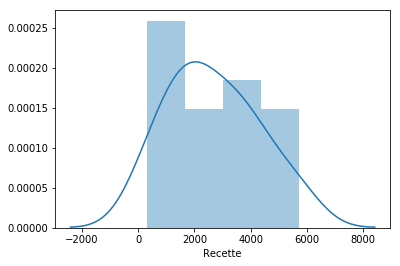

In [81]:
sb.distplot(recette.Recette)

D'après le graphique ci-dessus, on remarque qu'au milieu de l'année il y a une hausse des recettes : ce qui correspond au mois de juillet ainsi qu'au mois d'août : c'est la période estivale et donc la plus touristique.  

#### Classification
On souhaite pousser encore l'étude de la rentabilité des horodateurs de Paris en effectuant une classification non supervisée qui permettra de classer les horodateurs en fonction de leur rentabilité.

In [109]:
db = DBSCAN(eps = .9, min_samples = 4)
db.fit(scale(rentabilite[rentabilite.columns[:3]])) #normalisation des données

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=None, p=None)

Nous allons classer la rentabilité en 2 classes : 

In [110]:
regroup = np.unique(db.labels_, return_counts = True)
pd.DataFrame({
    "Classe" : regroup[0],
    "Nb_arrondissement" :regroup[1]
})

,Classe,Nb_arrondissement
0,-1,16
1,0,4


Notre rentabilité est regroupée en 2 classes : nous avons d'une part une rentabilité classée dans la classe -1 qui regoupe 16 arrondissements de Paris.  
Et d'une autre part, nous avons une rentabilité différente qui regroupe 4 arrondissements de Paris.

On décide alors d'effectué une analyse en composante principale afin de représenter au mieux nos deux classes.

In [113]:
pca = PCA()
pca.fit(scale(rentabilite[rentabilite.columns[:3]]))
rentabilite_pca = pca.transform(rentabilite[rentabilite.columns[:3]]) 

Création du tableau récapitulatif de notre ACP : 

In [116]:
tab_recap = pd.DataFrame(
    {
        'Dimension' : ['Dim' + str(x + 1) for x in range(3)], 
        'Valeur propre' : pca.explained_variance_,
        '% Variance expliquée' : np.round(pca.explained_variance_ratio_ * 100),
        '% cum. var. expliquée' : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)},
    columns = ['Dimension', 'Valeur propre', '% Variance expliquée', '% cum. var. expliquée']
)

tab_recap

,Dimension,Valeur propre,% Variance expliquée,% cum. var. expliquée
0,Dim1,1.929764,61.0,61.0
1,Dim2,0.860665,27.0,88.0
2,Dim3,0.367466,12.0,100.0


On remarque à l'aide du tableau récapitulatif, qu'avec 2 dimensions on peut expliquer 88% de la variance des données.  

On représente maintenant, le graphique des variances expliquées, passée en pourcentage : 

Text(2, 12.5, '12%')

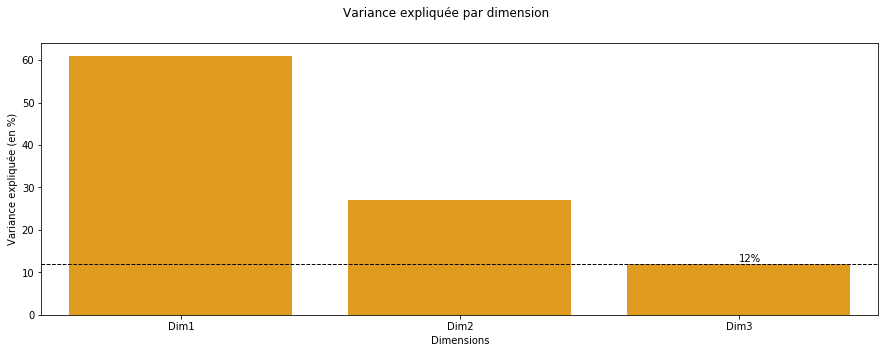

In [133]:
plt.figure(figsize=(15,5))
rpz_tab = sb.barplot(x = 'Dimension', 
                y = '% Variance expliquée',
                color = 'orange',
                data = tab_recap)

rpz_tab.set(ylabel = 'Variance expliquée (en %)', xlabel = 'Dimensions')
rpz_tab.figure.suptitle('Variance expliquée par dimension')
plt.axhline(y =12, linewidth = 1, color = 'black', linestyle = '--') 
plt.text(2, 12.5, '12%')

On crée maintenant un dataframe qui comprend les deux premières dimensions : 

In [137]:
df_acp_rentabilite = pd.DataFrame({
    "Dim1" : rentabilite_pca[:,0], 
    "Dim2" : rentabilite_pca[:,1], 
    "Arrondissement" : rentabilite.Arrondissement
})

Représentation sur le premier plan factoriel sur un seul graphique :

Text(0.5, 0.98, 'Premier plan factoriel')

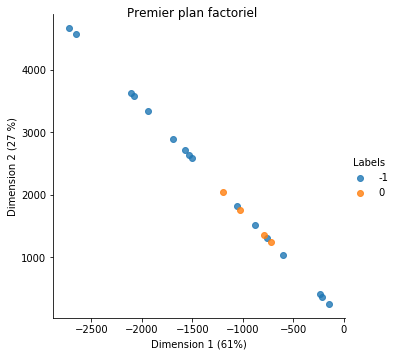

In [138]:
df_acp_rentabilite = df_acp_rentabilite.assign(Labels = db.labels_)

horo_acp = sb.lmplot("Dim1", "Dim2", hue = "Labels", data = df_acp_rentabilite, fit_reg = False)
horo_acp.set(xlabel = "Dimension 1 (61%)", ylabel = "Dimension 2 (27 %)")
horo_acp.fig.suptitle("Premier plan factoriel")

Ce plan principal comprend 88% de la variance ce qui est un bon résultat.  
La classe -1 contient une rentabilité très différente de celle de la classe 0.

Représentation sur le premier plan factoriel avec un graphique par classe : 

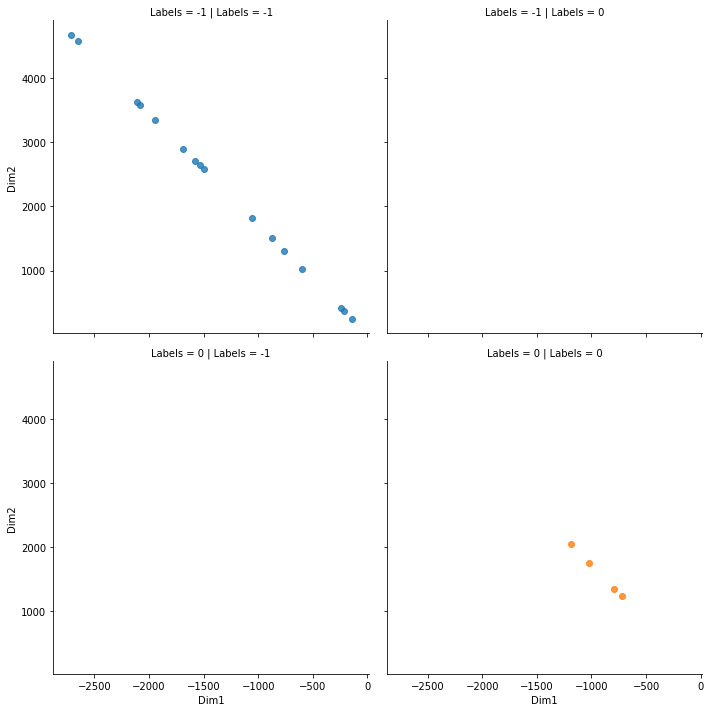

In [139]:
sb.lmplot("Dim1", "Dim2", hue = "Labels", col = "Labels", row = "Labels", data = df_acp_rentabilite, fit_reg = False)

Nous avons ici en bleu la rentabilité dans les 16 arrondissements de la classe -1 et en orange, la rentabilité dans les 4 arrondissements de la classe 0.
La rentabilité dans la classe -1 varie beaucoup, et celle la classe 0 est plus regroupée

Il y a des arrondissements qui rapportent plus que d'autres dans Paris, ce qui paraît logique : en effet, un arrondissement rapportera plus d'argent dans un quartier touristiques que dans un qui ne l'est pas.

# Conclusion
Nous avons étudié tout au long de ce projet les différents types d'horodateurs ainsi que les transactions effectués dans la ville de Paris.  
Nous avons commencé par étudier les mobiliers : 
- nous avons vu qu'il y avait deux types d'alimentations : ceux qui sont alimentés par le soleil, et ceux alimentés par piles
- nous avons regardé la répartition des horodateurs par arrondissement : il semble y en avoir le plus dans les arrondissements 13 à 20
- nous avons vu qu'il y avait 3 modèles d'horodateurs : `SAB3` celui qui semble le plus présent dans tout Paris, `SMB2` et `MUI` qui semble très peu présent voir inexistant
- nous avons regardé les types de régimes : les `MIX` qui sont situés sur les voies mixtes et donc plus présents, ainsi que les `ROT` situés sur les voies rotatives
- nous avons aussi remarqué que les tarifs sont fixes : pour les arrondissements du centre de Paris (1 à 11) le prix est fixé à 4€ alors que pour les autres il est fixé à 2.4€

Nous avons ensuite étudié les transactions :  
- nous avons remarqué que les arrondissements possédant le plus de transactions sont le quinzième et le seizième arrondissement alors que ceux qui ont eu le moins de transactions sont le premier et le deuxième qui sont des zones quand même très touristique : on peut quand même penser qu'étant donné qu'il existe les transports en commun et les zones semi-piétonne, il y a donc moins d'horodateurs dans ces zones
- nous avons constater que la rentabilité connaît une hausse au mois de juillet et août donc pendant la période estivale qui est une période très touristique

On a donc vu qu'en fonction de la localisation de l'horodateurs, il aura un type, un régime ainsi qu'un modèle précis.  Mais qu'en plus, il aura un prix fixe.   
Nous avons aussi conclut que plus l'arrondissement est touristique, moins il y aura d'horodateurs mais plus ça coûtera cher de s'y garer. 